# Kick test with Gaussian particles

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../')

from csr2d.kick import csr2d_kick_calc
import csr2d.kick2

In [3]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from scipy.interpolate import RectBivariateSpline, RegularGridInterpolator, interpn, interp2d

import scipy.constants
mec2 = scipy.constants.value('electron mass energy equivalent in MeV')*1e6
c_light = scipy.constants.c
e_charge = scipy.constants.e
r_e = scipy.constants.value('classical electron radius')

from scipy.interpolate import RectBivariateSpline

# Physical Parameters

In [4]:
#sigma_z = 40e-6
#sigma_x = 134e-6 
#rho = 1538.
#gamma = 58708.

sigma_z = 10e-6
sigma_x = 10e-6 
rho = 1.
gamma = 500.

Q = 2e-9

beta = np.sqrt(1 - 1 / gamma ** 2)
p0c = gamma*mec2

Nb = Q/e_charge

# Characteristic wake in eV/m from Chris's paper
W0 = Nb* r_e * mec2 *(sigma_z/abs(rho))**(2/3) / sigma_z**2

kick_factor = r_e * Nb / gamma 

print(f"""
Q       : {Q} C
sigma_x : {sigma_x} m
sigma_z : {sigma_z} m
rho     : {rho} m
gamma   : {gamma}
W0      : {W0:.3e} eV/m
""")


Q       : 2e-09 C
sigma_x : 1e-05 m
sigma_z : 1e-05 m
rho     : 1.0 m
gamma   : 500.0
W0      : 8.343e+07 eV/m



# Make particles

In [5]:
def test_particles(n_particle=1000000,
               sigma_x = 0.001,
               sigma_z = 0.001,
               total_charge = 1e-9,
               mean_x = 0,
               mean_z = 0):
    """
    Test Gaussian bunch to compare with OpenSpaceCharge
    
    Returns tuple:
        particles_xyz, weights
    """
    
    mean = [mean_x, mean_z]
    cov = np.diag([sigma_x**2, sigma_z**2])
    
    p = np.random.multivariate_normal(mean, cov, n_particle)
    weights = np.full(n_particle, total_charge/n_particle)
    
    z = p[:,1]
    x = p[:,0]
    return z, x, weights

In [6]:
%%time
Np = 1_000_000

zi, xi, charges = test_particles(Np, sigma_x=sigma_x, sigma_z=sigma_z, total_charge=Q)

CPU times: user 191 ms, sys: 18.6 ms, total: 209 ms
Wall time: 88.2 ms


Text(0.5, 1.0, '1D Steady-state wake')

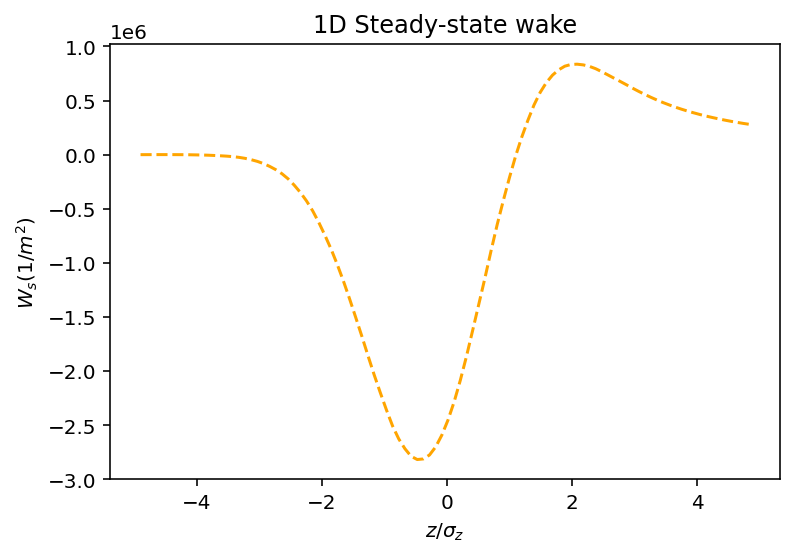

In [23]:
# 1D CSR steady state wake
SS = csr2d.kick2.csr1d_steady_state_kick_calc(zi, charges, normalized_units=True)
plt.plot(SS['zvec']/sigma_z, SS['wake'], color='orange', linestyle='--', label='1D steady-state')
plt.xlabel(r'$z/\sigma_z$')
plt.ylabel(r'$W_s (1/m^2)$')
plt.title('1D Steady-state wake')

# CSR 2D kick

Compare internal methods

In [8]:
# Parameters
nx = 512
nz = 512

# Average particles/cell
Np/(nx*nz)

3.814697265625

In [9]:
%%time
# Current method
O1 = csr2d_kick_calc(zi, xi, charges, gamma=gamma, rho=rho, nz=nz, nx=nx,
                                     map_f = map, debug=True)

Depositing particles takes: 0.6726362705230713 s


../../csr2d/core.py:16: RuntimeWarning: invalid value encountered in true_divide
  out = (cos(2 * alpha(z, x, beta)) - 1 / (1+x)) / (
../../csr2d/core.py:58: RuntimeWarning: divide by zero encountered in true_divide
  arg2 = -4 * (1+x) / x**2
../../csr2d/core.py:60: RuntimeWarning: divide by zero encountered in true_divide
  T1 = (1/abs(x)/(1 + x) * ((2 + 2*x + x**2) * ss.ellipkinc(alp, arg2)- x**2 * ss.ellipeinc(alp, arg2)))
../../csr2d/core.py:60: RuntimeWarning: invalid value encountered in multiply
  T1 = (1/abs(x)/(1 + x) * ((2 + 2*x + x**2) * ss.ellipkinc(alp, arg2)- x**2 * ss.ellipeinc(alp, arg2)))
../../csr2d/core.py:65: RuntimeWarning: divide by zero encountered in true_divide
  T5 = 1 / abs(x) * ss.ellipkinc(alp, arg2)  # psi_phi without e/rho**2 factor
../../csr2d/core.py:65: RuntimeWarning: invalid value encountered in multiply
  T5 = 1 / abs(x) * ss.ellipkinc(alp, arg2)  # psi_phi without e/rho**2 factor
../../csr2d/core.py:62: RuntimeWarning: invalid value encountered in 

Computing potential grids take: 6.279186010360718 s
Convolution takes: 0.27060389518737793 s
Interpolation takes: 1.1121830940246582 s
CPU times: user 9.5 s, sys: 222 ms, total: 9.72 s
Wall time: 8.61 s


In [10]:
%%time
# New method with spline interpolation
O2 = csr2d.kick2.csr2d_kick_calc(zi, xi, charges, gamma=gamma, rho=rho, nz=nz, nx=nx,
                                     map_f = map, debug=True, imethod='spline')

Depositing particles takes: 0.026862144470214844 s
Computing potential grids take: 0.1057138442993164 s
Convolution takes: 0.1205911636352539 s
Interpolation with spline takes: 1.1360390186309814 s
CPU times: user 4.45 s, sys: 166 ms, total: 4.61 s
Wall time: 1.7 s


In [11]:
%%time
# New method with map_coordinates interpolation
O3 = csr2d.kick2.csr2d_kick_calc(zi, xi, charges, gamma=gamma, rho=rho, nz=nz, nx=nx,
                                     map_f = map, debug=True, imethod='map_coordinates')

Depositing particles takes: 0.026845216751098633 s
Computing potential grids take: 0.10790228843688965 s
Convolution takes: 0.09963583946228027 s
Interpolation with map_coordinates takes: 0.2725660800933838 s
CPU times: user 3.74 s, sys: 136 ms, total: 3.87 s
Wall time: 783 ms


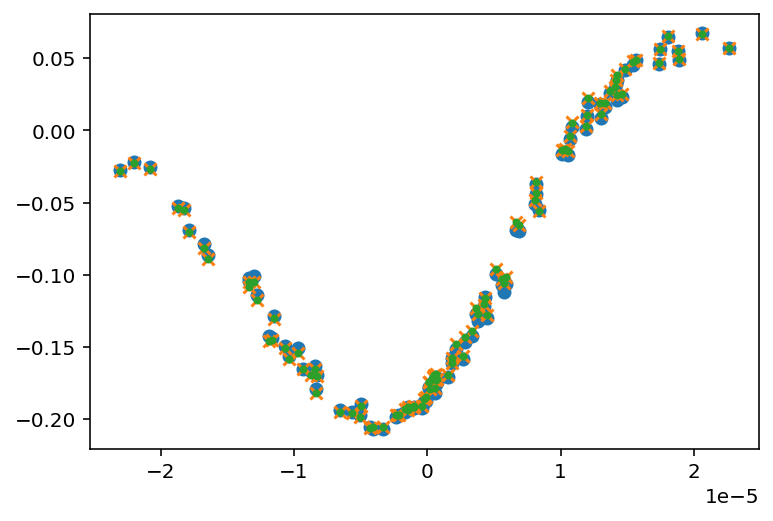

In [12]:
# Look at some of the particle kicks
skip = 10000
plt.scatter(zi[::skip], O1['ddelta_ds'][::skip], marker='o')
plt.scatter(zi[::skip], O2['ddelta_ds'][::skip], marker='x')
plt.scatter(zi[::skip], O3['ddelta_ds'][::skip], marker='.')

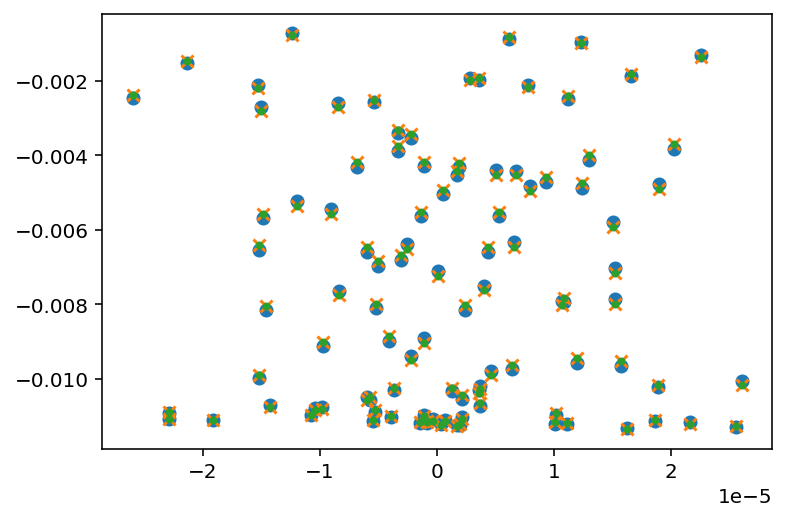

In [13]:
plt.scatter(xi[::skip], O1['dxp_ds'][::skip], marker='o')
plt.scatter(xi[::skip], O2['dxp_ds'][::skip], marker='x')
plt.scatter(xi[::skip], O3['dxp_ds'][::skip], marker='.')

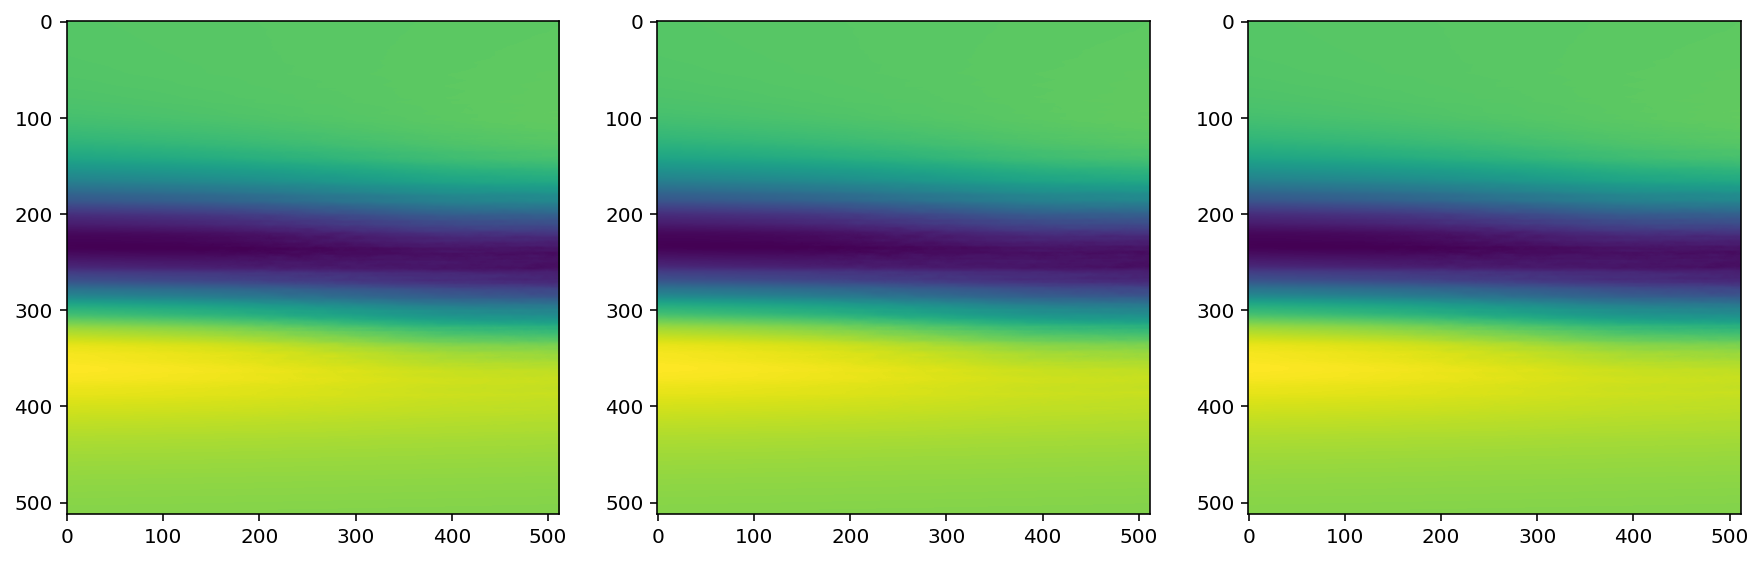

In [14]:
# Wakes
def compare_grids(key):
    fig, axes = plt.subplots(1,3, figsize=(15,8))
    axes[0,].imshow(O1[key])
    axes[1,].imshow(O2[key])
    axes[2,].imshow(O3[key])
compare_grids('Ws_grid')   

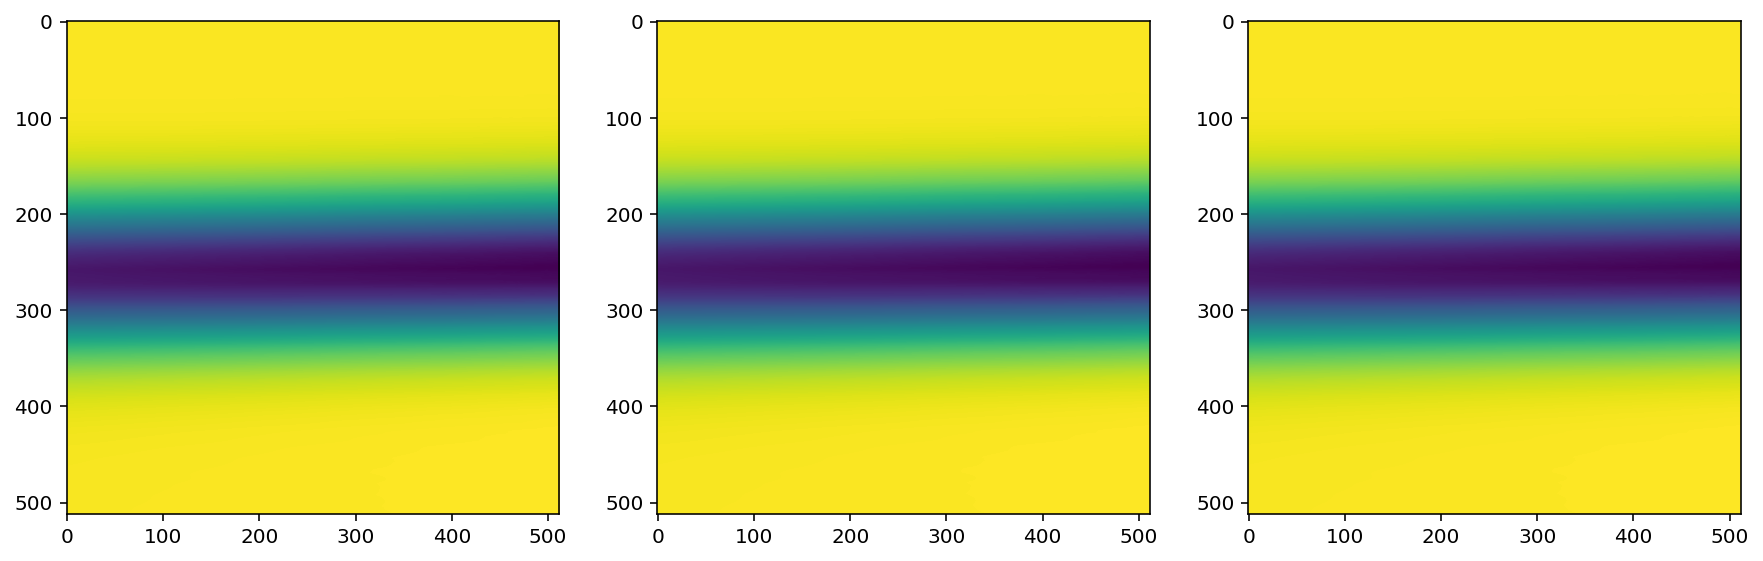

In [15]:
compare_grids('Wx_grid')   

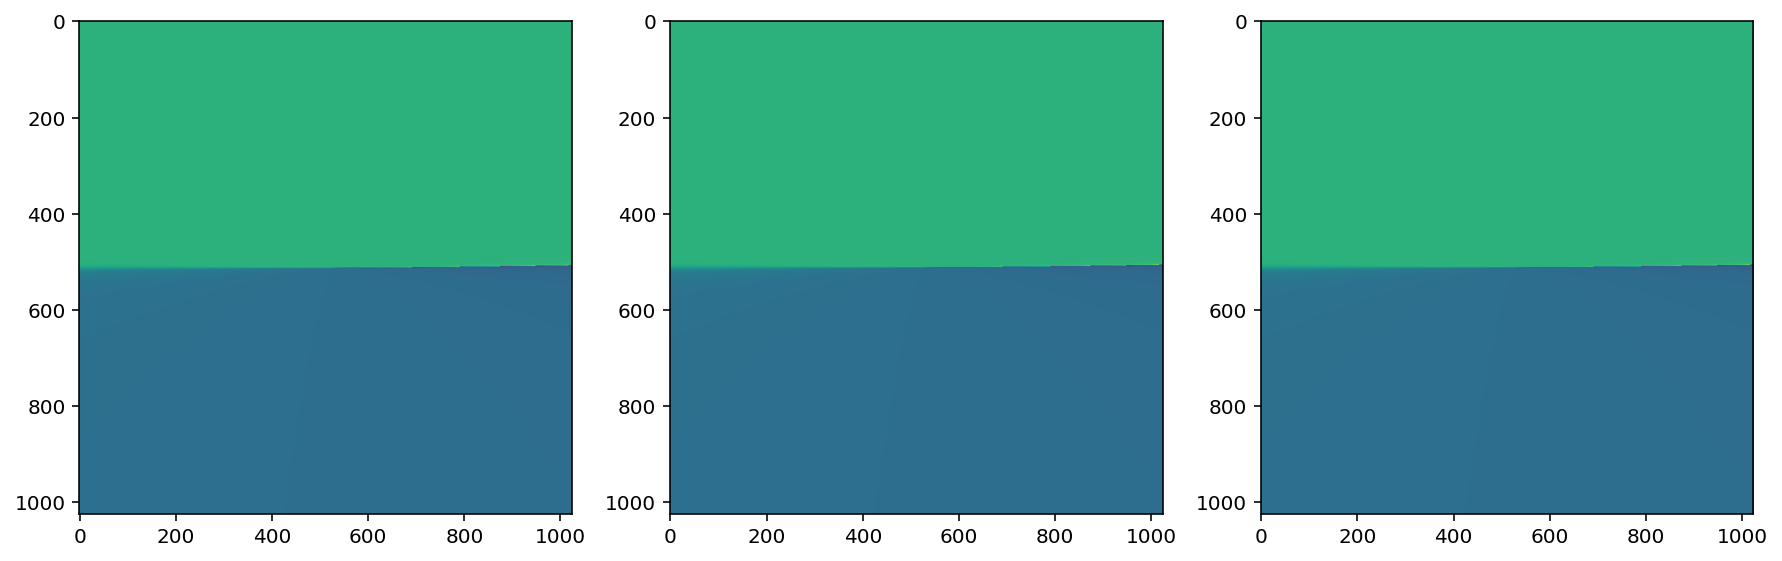

In [16]:
compare_grids('psi_x_grid')   

# Wake plots

In [17]:
# Convenient trick to avoid typing O3['key']
from types import SimpleNamespace 

O = SimpleNamespace(**O3)

In [18]:
Ws_interp = RectBivariateSpline(O.zvec, O.xvec, O.Ws_grid)
Wx_interp = RectBivariateSpline(O.zvec, O.xvec, O.Wx_grid)

zmin, zmax, xmin, xmax = O.zvec.min(), O.zvec.max(), O.xvec.min(), O.xvec.max()

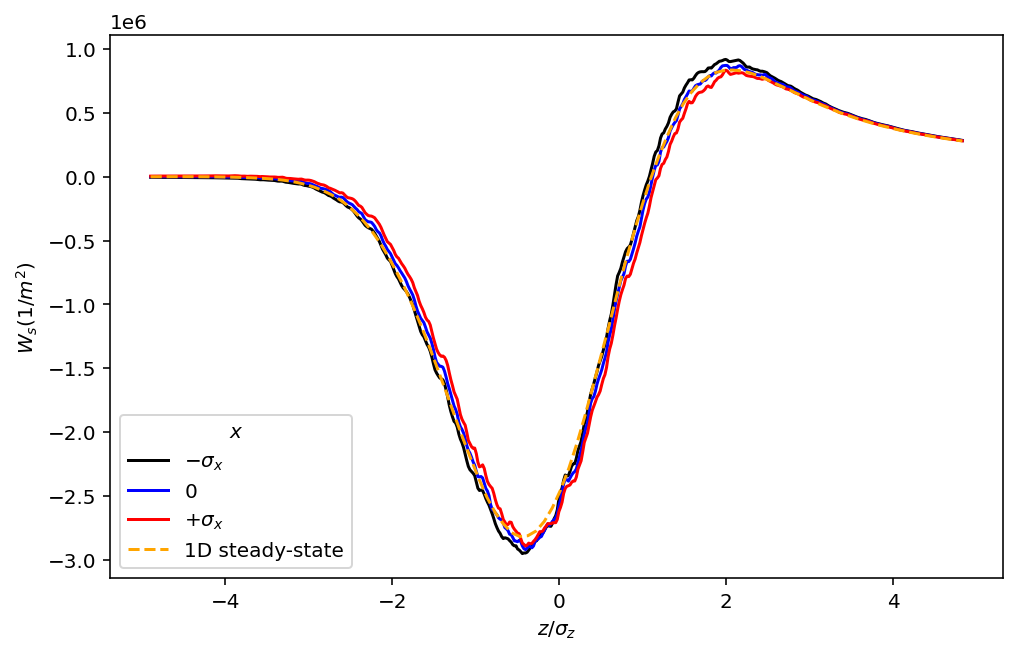

In [19]:
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(O.zvec/sigma_z,  Ws_interp.ev(O.zvec, -sigma_x), color='black', label=r'$-\sigma_x$')
ax.plot(O.zvec/sigma_z,  Ws_interp.ev(O.zvec,  0),       color='blue', label=r'$0$')    
ax.plot(O.zvec/sigma_z,  Ws_interp.ev(O.zvec, sigma_x),  color='red', label=r'$+\sigma_x$')   
ax.plot(SS['zvec']/sigma_z, SS['wake'], color='orange', linestyle='--', label='1D steady-state')
ax.set_xlabel(r'$z/\sigma_z$')
ax.set_ylabel(r'$W_s (1/m^2)$')
ax.legend(title='$x$')

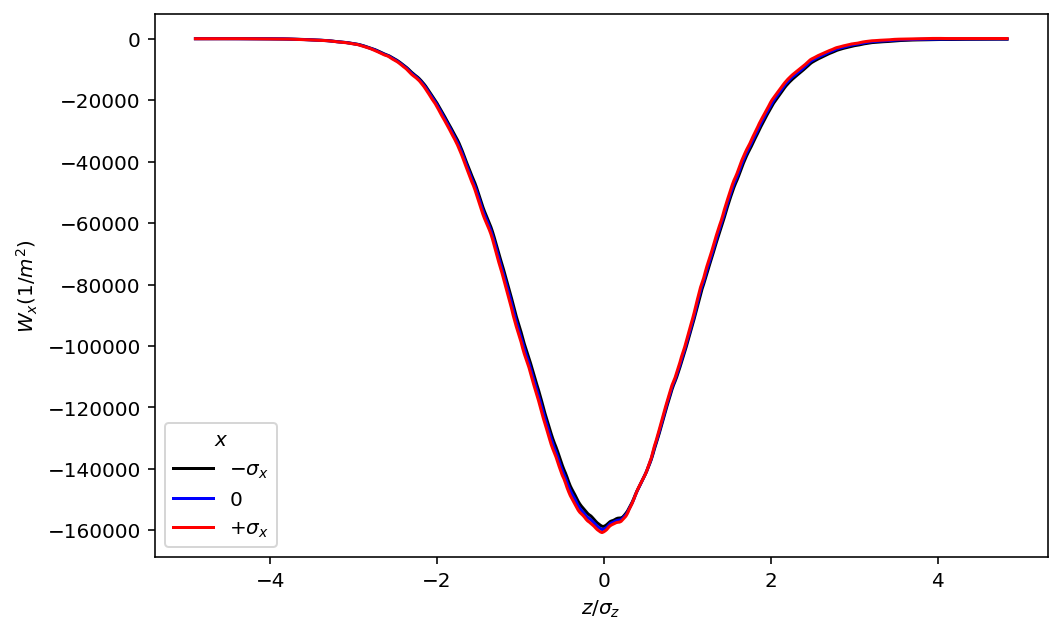

In [20]:
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(O.zvec/sigma_z,  Wx_interp.ev(O.zvec, -sigma_x), color='black', label=r'$-\sigma_x$')
ax.plot(O.zvec/sigma_z,  Wx_interp.ev(O.zvec,  0),       color='blue', label=r'$0$')    
ax.plot(O.zvec/sigma_z,  Wx_interp.ev(O.zvec, sigma_x),  color='red', label=r'$+\sigma_x$')   
ax.set_xlabel(r'$z/\sigma_z$')
ax.set_ylabel(r'$W_x (1/m^2)$')
ax.legend(title='$x$')

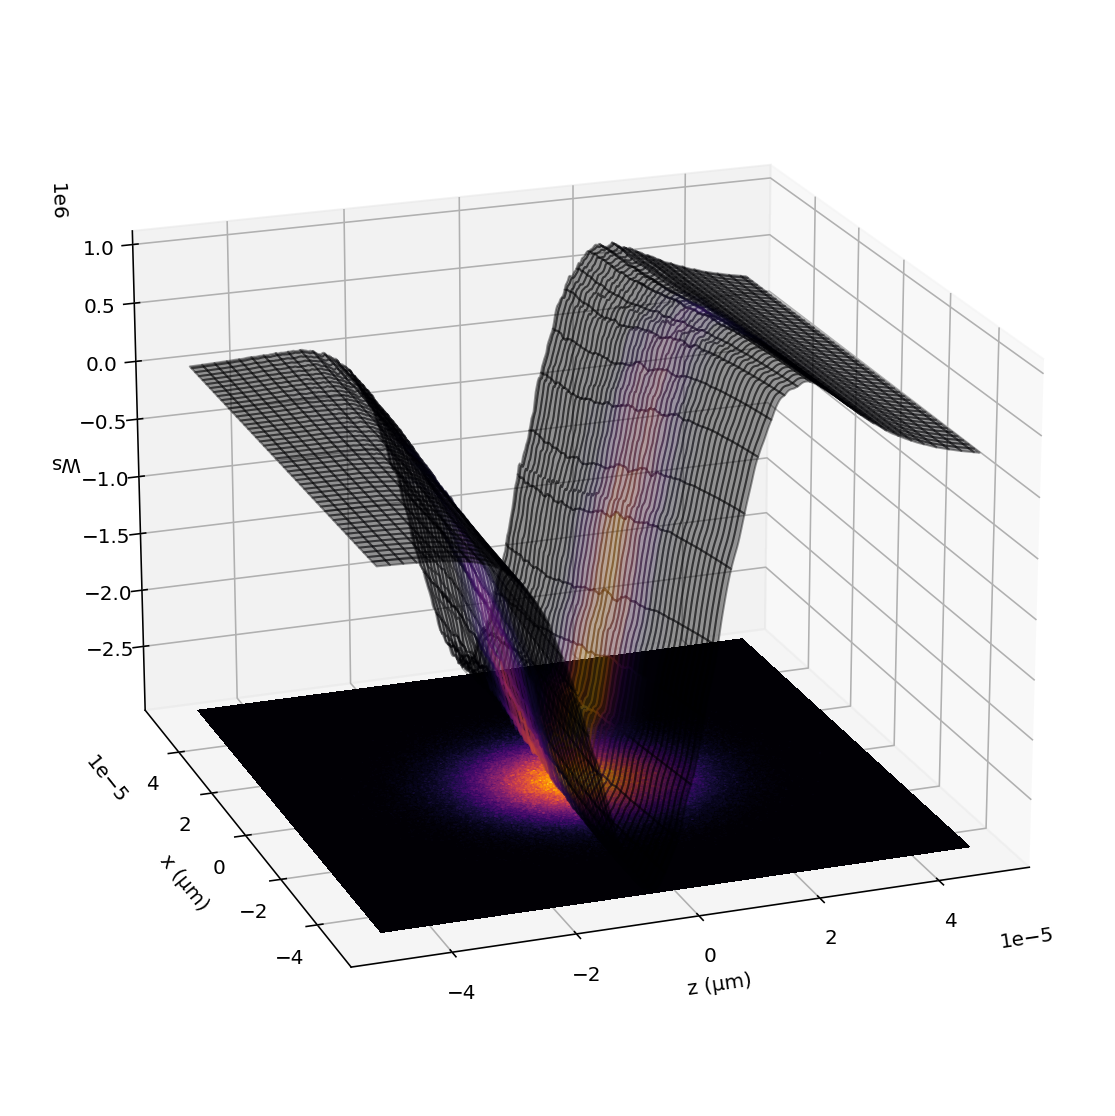

In [21]:
LABEL='Ws'

Z, X = np.meshgrid(O.zvec, O.xvec, indexing="ij")
W = O.Ws_grid
cdata = O.charge_grid

from mpl_toolkits.mplot3d import Axes3D
cmap = matplotlib.cm.get_cmap('inferno')


colors = cmap(cdata/cdata.max())
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Z, X, W, alpha=0.4, facecolors=colors)
#ax.contourf(Z, X, W, zdir='y', offset=Z.min(), cmap=matplotlib.cm.coolwarm)
ax.contourf(Z, X, cdata, 100, zdir='z', offset=W.min(), extent=[zmin, zmax, xmin, xmax], cmap=cmap)
#ax.set_title('2D CSR wake')
ax.set_xlabel('z (µm)')
ax.set_ylabel('x (µm)')
ax.zaxis.set_rotate_label(False)
ax.set_zlabel(LABEL, rotation=180)
ax.view_init(20, 250)
#plt.savefig(f'{KEY}_3d.png', dpi=150)

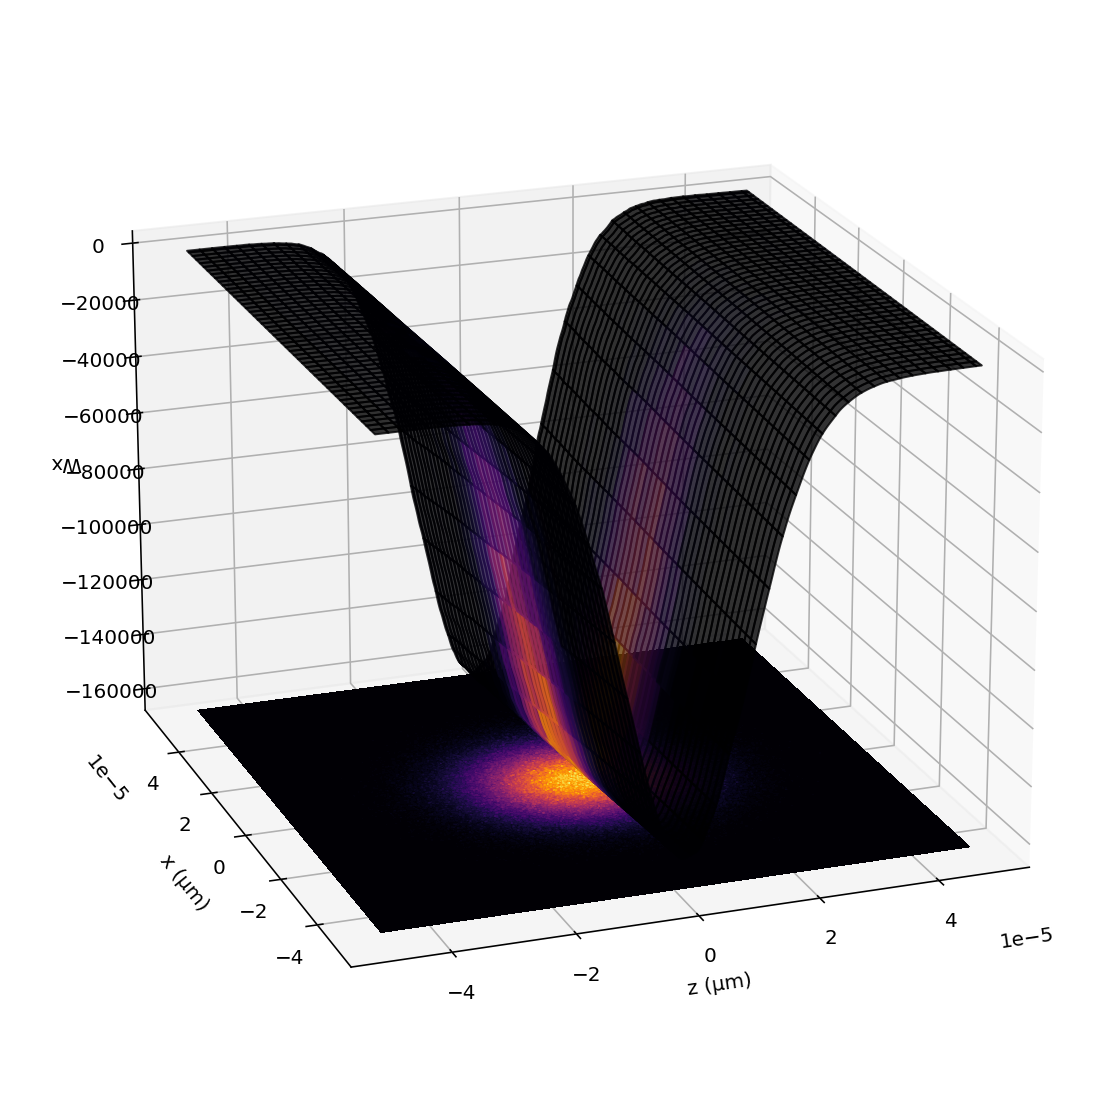

In [22]:
LABEL='Wx'

Z, X = np.meshgrid(O.zvec, O.xvec, indexing="ij")
W = O.Wx_grid
cdata = O.charge_grid

from mpl_toolkits.mplot3d import Axes3D
cmap = matplotlib.cm.get_cmap('inferno')


colors = cmap(cdata/cdata.max())
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Z, X, W, alpha=0.8, facecolors=colors)
#ax.contourf(Z, X, W, zdir='y', offset=Z.min(), cmap=matplotlib.cm.coolwarm)
ax.contourf(Z, X, cdata, 100, zdir='z', offset=W.min(), extent=[zmin, zmax, xmin, xmax], cmap=cmap)
#ax.set_title('2D CSR wake')
ax.set_xlabel('z (µm)')
ax.set_ylabel('x (µm)')
ax.zaxis.set_rotate_label(False)
ax.set_zlabel(LABEL, rotation=180)
ax.view_init(20, 250)
#plt.savefig(f'{KEY}_3d.png', dpi=150)